In [1]:
!git clone https://github.com/tiasa2/Sad_Depression_Classification.git

Cloning into 'Sad_Depression_Classification'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 7), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
!pip install transformers==3

     |████████████████████████████████| 754 kB 12.0 MB/s 
     |████████████████████████████████| 3.0 MB 39.6 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Use GPU
device = torch.device("cuda")

In [5]:
!ls ./Sad_Depression_Classification/

ACL_FINAL_Data.csv	 BERT_Baseline.ipynb	    README.md
ALBERT_Depression.ipynb  DistilBert_Baseline.ipynb  Roberta_Baseline.ipynb


In [6]:
df = pd.read_csv("./Sad_Depression_Classification/ACL_FINAL_Data.csv")
df.head()

,Unnamed: 0,tweet,target
0,251,i feel guilty i wont be able to give this litt...,0
1,2295,There’s no point in even trying anymore. It’s ...,1
2,918,i was taught to complain and feel unhappy but ...,0
3,1990,There are probably serial killers who sleep ea...,1
4,1241,"His brown , nearly auburn hair clung to his sc...",0


In [7]:
print (len(df))

3256


In [8]:
df.rename(columns = {'Text':'tweet', 'Label':'target'}, inplace = True)
df.target = df.target.astype(int)
df.head(20)

,Unnamed: 0,tweet,target
0,251,i feel guilty i wont be able to give this litt...,0
1,2295,There’s no point in even trying anymore. It’s ...,1
2,918,i was taught to complain and feel unhappy but ...,0
3,1990,There are probably serial killers who sleep ea...,1
4,1241,"His brown , nearly auburn hair clung to his sc...",0
5,1724,im feeling like the lunches are dull,0
6,726,i feel rotten but no amount of suggesting that...,0
7,1242,I am sad because some relations to friends are...,0
8,1132,The loss of a person I loved very much is some...,0
9,706,i forgive myself that i have accepted and allo...,0


In [9]:
# Displaying Class distribution
df['target'].value_counts(normalize = True)

0    0.587838
1    0.412162
Name: target, dtype: float64

In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['target'])

# Using temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.1, 
                                                                stratify=temp_labels)

In [11]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [12]:
# Sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# Encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


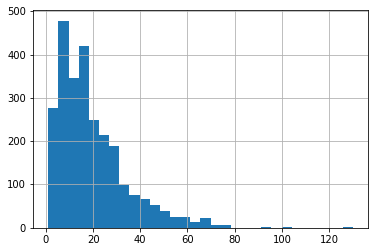

In [13]:
# Getting length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [14]:
max_seq_len = 25
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [15]:
# Converting Integer Sequences to Tensor

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [17]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [18]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

In [19]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)

In [20]:
# Optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [21]:
# Finding class weights

from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.85042456 1.21342032]


In [22]:
# Convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# Loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# Number of training epochs
epochs = 8


In [23]:
# Function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]
  
  # Iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Append the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds

In [24]:
# Function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [25]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# For each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.659
Validation Loss: 0.560

 Epoch 2 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.556
Validation Loss: 0.586

 Epoch 3 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.460
Validation Loss: 0.392

 Epoch 4 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.505
Validation Loss: 0.427

 Epoch 5 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.438
Validation Loss: 0.352

 Epoch 6 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.420
Validation Loss: 0.385

 Epoch 7 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.406
Validation Loss: 0.340

 Epoch 8 / 8
  Batch    50  of     82.

Evaluating...

Training Loss: 0.413
Validation Loss: 0.330


In [26]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [28]:
# Model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        39
           1       0.88      0.81      0.85        27

    accuracy                           0.88        66
   macro avg       0.88      0.87      0.87        66
weighted avg       0.88      0.88      0.88        66



In [29]:
# Confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,36,3
1,5,22


In [30]:
print (type(test_y))

<class 'torch.Tensor'>


In [31]:
print (test_y)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0])


In [32]:
testy_list = test_y.tolist()
print (testy_list)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]


In [33]:
preds_list = preds.tolist()
print (preds_list)

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]


In [34]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(testy_list, preds_list)

#Printing per class accuracy
print (100*matrix.diagonal()/matrix.sum(axis=1))


[92.30769231 81.48148148]


In [35]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(testy_list, preds_list)

print (acc)

0.8787878787878788


In [36]:
print (len(testy_list))

66


In [38]:
!cp saved_weights.pt BERT_Baseline_weights.pt

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
!mv BERT_Baseline_weights.pt /content/drive/MyDrive/Sad_Depression_Classification/BERT_Baseline_weights.pt